In [1]:
import os
import math
import csv
import datetime
import pickle
import numpy
import numpy as np
import pandas as pd
from glob import glob
import matplotlib.pyplot as plt
from matplotlib.dates import DateFormatter

import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots

from tslearn.clustering import silhouette_score
from tslearn.generators import random_walks
from tslearn.metrics import cdist_dtw
from tslearn.clustering import KShape
from tslearn.clustering import TimeSeriesKMeans
from tslearn.datasets import CachedDatasets
from tslearn.preprocessing import TimeSeriesScalerMeanVariance, TimeSeriesResampler

import networkx as nx
import matplotlib as mpl
import seaborn as sns 
import json
from networkx.drawing.nx_agraph import graphviz_layout
import geopandas as gpd
from shapely import wkt
from shapely.geometry import Point
from shapely.geometry import Polygon
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import statistics 

/usr/local/lib/python3.7/site-packages/sklearn/utils/deprecation.py:143: FutureWarning: The sklearn.cluster.k_means_ module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.cluster. Anything that cannot be imported from sklearn.cluster is now part of the private API.
  warnings.warn(message, FutureWarning)
/usr/local/lib/python3.7/site-packages/tslearn/bases.py:14: UserWarning: h5py not installed, hdf5 features will not be supported.
Install h5py to use hdf5 features: http://docs.h5py.org/
  warn(h5py_msg)


# Pie

In [2]:
def process_visits(city,dates,n):
    dfs = []
    for file in sorted(glob(os.path.join('pie_visits/'+city+'/', '*.csv'))):
        df = pd.read_csv(file, header=None)        
        tmp = df[:n]
        df = tmp.append(pd.DataFrame([['Other',df[n:][1].sum()]]),ignore_index=True)
        
        df.columns = ['category', 'count']
        df['city'] = city
        df['date'] = dates[0]
        dates.pop(0)
        
        dfs.append(df)
    
    df = pd.concat(dfs,ignore_index=True)
    return df,dfs

In [3]:
dates = ['1-27','2-24','3-30','4-27']

ny = process_visits('new york',dates.copy(),7)[0]
austin = process_visits('austin',dates.copy(),7)[0]
sf = process_visits('san francisco',dates.copy(),7)[0]
seattle = process_visits('seattle',dates.copy(),7)[0]

In [4]:
total = []
total.append(ny)
total.append(austin)
total.append(sf)
total.append(seattle)

tf = pd.concat(total,ignore_index=True)
categories = list(tf.category.unique())

colors = ['#a6cee3','#1f78b4','#fdbf6f','#ff7f00','#e31a1c','#6a3d9a','#fb9a99','#b2df8a','#cab2d6','#ffff99','#33a02c','#b15928']
colorscale = {categories[i]: colors[i] for i in range(len(categories))} 

In [5]:
ny = process_visits('new york',dates.copy(),7)[1]
austin = process_visits('austin',dates.copy(),7)[1]
sf = process_visits('san francisco',dates.copy(),7)[1]
seattle = process_visits('seattle',dates.copy(),7)[1]

In [6]:
for city in [ny,austin,sf,seattle]:
    to_plot = []
    for df in city: 
        df['color'] = df['category'].map(colorscale)
        to_plot.append(df)
    city = to_plot

In [7]:
# FINAL PAPER FIGURE

specs = [[{'type':'domain'}]*4]*4
fig = make_subplots(rows=4, cols=4)

for i, city1 in enumerate(ny):
    fig.add_trace(go.Pie(labels=city1['category'].values, values=city1['count'].values,domain={'x': [i/4, i/4+0.25], 'y': [0.80, 1]},sort=False,marker_colors=city1['color'].values))
    
for i, city1 in enumerate(austin):
    fig.add_trace(go.Pie(labels=city1['category'].values, values=city1['count'].values,domain={'x': [i/4, i/4+0.25], 'y': [0.55, 0.75]},sort=False,marker_colors=city1['color'].values))
    
for i, city1 in enumerate(sf):
    fig.add_trace(go.Pie(labels=city1['category'].values, values=city1['count'].values,domain={'x': [i/4, i/4+0.25], 'y': [0.30, 0.50]},sort=False,marker_colors=city1['color'].values))

for i, city1 in enumerate(seattle):
    fig.add_trace(go.Pie(labels=city1['category'].values, values=city1['count'].values,domain={'x': [i/4, i/4+0.25], 'y': [0.05, 0.25]},sort=False,marker_colors=city1['color'].values))

# Use `hole` to create a donut-like pie chart
fig.update_traces(hole=.42)

# Donut labels
annotations = []

for x in [0.09,0.375,0.625,0.91]:
    annotations.append(dict(text='<b>New York</b>', x=x, y=0.917, font_size=10, showarrow=False))
    
for x in [0.1,0.375,0.625,0.897]:
    annotations.append(dict(text='<b>Austin</b>', x=x, y=0.66, font_size=10, showarrow=False))
    
for x in [0.09,0.375,0.625,0.91]:
    annotations.append(dict(text='<b>San<br>Francisco</b>', x=x, y=0.415, font_size=10, showarrow=False))
    
for x in [0.097,0.375,0.625,0.9]:
    annotations.append(dict(text='<b>Seattle</b>', x=x, y=0.15, font_size=10, showarrow=False))

for y in [0.901,0.6425,0.39,0.133]:
    annotations.append(dict(text='January', x=0.099, y=y, font_size=10, showarrow=False))
    annotations.append(dict(text='February', x=0.375, y=y, font_size=10, showarrow=False))
    annotations.append(dict(text='March', x=0.625, y=y, font_size=10, showarrow=False))
    annotations.append(dict(text='April', x=0.89, y=y, font_size=10, showarrow=False))

fig.update_layout(height=1000, width=950,margin=dict(l=0, r=0, t=0, b=0),annotations=annotations)

fig.update_layout(legend_orientation="h",legend=dict(x=0.05, y=0))
fig.update_traces(textfont_size=10)
fig.show()

In [8]:
# SUPPLEMENTAL REFERENCE FIGURE
dates = ['1-27','2-24','3-30','4-27']

city = 'dallas'
cur = process_visits(city,dates.copy(),7)[1]

# use same colorscale as above
to_plot = []
for df in cur: 
    df['color'] = df['category'].map(colorscale)
    to_plot.append(df)
cur = to_plot

# replace label to be more concise
for i in range(0,4):
    cur[i] = cur[i].replace('General Merchandise Stores, including Warehouse Clubs and Supercenters', 'General Merchandise Stores, including<br>Warehouse Clubs and Supercenters')

# add new category with color
colorscale['Religious Organizations'] = '#ff63d3'

# plot figure
specs = [[{'type':'domain'}]*4]
fig = make_subplots(rows=1, cols=4, vertical_spacing=0.2)

for i, city1 in enumerate(cur):
    fig.add_trace(go.Pie(labels=city1['category'].values, values=city1['count'].values,domain={'x': [i/4, i/4+0.25], 'y': [0.15, 1]},sort=False,marker_colors=city1['color'].values))

fig.update_traces(hole=.42)
annotations = []

for x in [0.102,0.375,0.625,0.896]:
    annotations.append(dict(text='<b>Dallas</b>', x=x, y=0.615, font_size=10, showarrow=False))

annotations.append(dict(text='January', x=0.099, y=0.54, font_size=10, showarrow=False))
annotations.append(dict(text='February', x=0.375, y=0.54, font_size=10, showarrow=False))
annotations.append(dict(text='March', x=0.625, y=0.54, font_size=10, showarrow=False))
annotations.append(dict(text='April', x=0.89, y=0.54, font_size=10, showarrow=False))

fig.update_layout(height=315, width=950,margin=dict(l=0, r=0, t=0, b=0),annotations=annotations)

fig.update_layout(legend_orientation="h",legend=dict(x=0.05, y=0))
fig.update_traces(textfont_size=10)
fig.show()

# Radar

In [9]:
def process_poi(city,n):
    dfs = []
    for file in sorted(glob(os.path.join('radar/'+city+'/', '*.csv'))):
        df = pd.read_csv(file, nrows=n, header=None)
        df.columns = ['category', 'count']
        df.loc[df['count'] > 0, 'count'] = 1
        df['city'] = city
        dfs.append(df)
        
    df = pd.concat(dfs,ignore_index=True)
    df = df.groupby(['category']).sum().reset_index()
    df = df.sort_values('count',ascending=False)

    return df

In [10]:
ny = process_poi('new york',5)
austin = process_poi('austin',5)
sf = process_poi('san francisco',5)
seattle = process_poi('seattle',5)

In [11]:
process_labels = {'Museums, Historical Sites, and Similar Institutions':'Museums, Historical Sites,<br>and Similar Institutions',
       'Other Amusement and Recreation Industries':'Other Amusement and<br>Recreation Industries',
       'Restaurants and Other Eating Places':'Restaurants and Other<br>Eating Places',
       'Elementary and Secondary Schools':'Elementary and<br>Secondary Schools',
       'Colleges, Universities, and Professional Schools':'Colleges, Universities, and<br>Professional Schools',
       'General Merchandise Stores, including Warehouse Clubs and Supercenters':'General Merchandise Stores,<br>including Warehouse Clubs<br>and Supercenters',
       'Support Activities for Air Transportation':'Support Activities for Air<br>Transportation',
        'Motion Picture and Video Industries':'Motion Picture and Video<br>Industries',
        'Sporting Goods, Hobby, and Musical Instrument Stores':'Sporting Goods, Hobby, and<br>Musical Instrument Stores',
        'Other Information Services':'Other Information<br>Services'
       }

for key,val in process_labels.items():
    ny = ny.replace(key,val)
    austin = austin.replace(key,val)
    sf = sf.replace(key,val)
    seattle = seattle.replace(key,val)

In [12]:
fig = make_subplots(rows=2, cols=2, specs=[[{'type': 'polar'}]*2]*2, horizontal_spacing=0.15, vertical_spacing=0.25)

fig.add_trace(go.Scatterpolar(
      r = ny['count'].values,
      theta = list(ny['category'].values),
    line_color = '#85c9b5'
    ), 1, 1)

fig.add_trace(go.Scatterpolar(
      r = austin['count'].values,
      theta = list(austin['category'].values),
    line_color = '#789cad'
    ), 1, 2)

fig.add_trace(go.Scatterpolar(
      r = sf['count'].values,
      theta = list(sf['category'].values),
    line_color = '#a7c9ae'
    ), 2, 1)

fig.add_trace(go.Scatterpolar(
      r = seattle['count'].values,
      theta = list(seattle['category'].values),
    line_color = '#8787ad'
    ), 2, 2)

layout = dict(
        radialaxis = dict(range=[0, 4],linewidth = 1,gridwidth = 1,dtick = 1,tickfont_size=10,tickprefix="   "),
        angularaxis = dict(gridwidth=1,linewidth = 1.5))

fig.update_traces(fill='toself')
fig.update_layout(
    font_size=12,
    template=None,
    polar = layout,
    polar2 = layout,
    polar3 = layout,
    polar4 = layout
)

fig.update_layout(height=600, width=1000)
fig.update_layout(showlegend=False)
fig.show()

# Clustering

In [13]:
path_dataframe = os.getcwd()
os.chdir(path_dataframe)

city_df = os.listdir()
city_df_dict = {}
for each in city_df:
    if each.split('.')[-1] == 'pkl':
        with open(each, 'rb') as file:
            city_df_dict[each.split('_')[0]] = pickle.load(file)
            
connect_frame = []
for key,values in city_df_dict.items():
    temp_city_df =  pd.Series(values[['hh_proportion', 'nh_proportion']].sum(axis=1), name=key).to_frame()
    connect_frame.append(temp_city_df)
    
city_hh_nh = pd.concat(connect_frame, axis=1, ignore_index=False, sort=False)
X_train = city_hh_nh.T.to_numpy()
X_train = TimeSeriesScalerMeanVariance().fit_transform(X_train)
sz = X_train.shape[1]

In [14]:
seed = 0

# Euclidean-k-means
km = TimeSeriesKMeans(n_clusters=2, verbose=True, random_state=seed)
y_pred_km = km.fit_predict(X_train)

# DBA-k-means
dba_km = TimeSeriesKMeans(n_clusters=2,
                          n_init=2,
                          metric="dtw",
                          verbose=True,
                          max_iter_barycenter=10,
                          random_state=seed)
y_pred_dba = dba_km.fit_predict(X_train)

# Soft-DTW-k-means
sdtw_km = TimeSeriesKMeans(n_clusters=2,
                           metric="softdtw",
                           metric_params={"gamma": .01},
                           verbose=True,
                           random_state=seed)
y_pred_sdtw_km = sdtw_km.fit_predict(X_train)

# k-Shape
ks = KShape(n_clusters=2, verbose=True, random_state=seed)
y_pred_ks = ks.fit_predict(X_train)

15.339 --> 10.105 --> 10.105 --> 
Init 1


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  32 out of  32 | elapsed:    0.7s finished


6.347 --> 

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  32 out of  32 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  32 out of  32 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  32 out of  32 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  32 out of  32 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  32 out of  32 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  32 out of  32 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_j

4.337 --> 4.337 --> 
Init 2
7.910 --> 4.332 --> 4.211 --> 4.211 --> 
90.019 --> 36.908 --> 36.851 --> 36.881 --> 36.869 --> 36.876 --> 36.872 --> 36.877 --> 36.870 --> 36.877 --> 36.843 --> 36.874 --> 36.870 --> 36.875 --> 36.868 --> 36.872 --> 36.872 --> 36.872 --> 36.872 --> 
0.178 --> 0.157 --> 0.133 --> 0.132 --> 0.148 --> 


Text(0.08, 0.5, 'Proportion of HH + NH')

<Figure size 432x288 with 0 Axes>

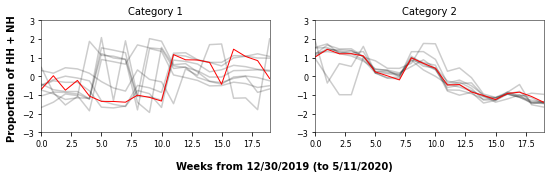

In [15]:
# FINAL PAPER FIGURE
plt.figure()
fig, ax1 = plt.subplots(figsize=(9,7))
fig.patch.set_facecolor('white')

for yi in range(2):
    plt.subplot(3, 2, 3 + yi)
    for xx in X_train[y_pred_dba == yi]:
        plt.plot(xx.ravel(), "k-", alpha=.2)
    plt.plot(dba_km.cluster_centers_[yi].ravel(), "r-",linewidth=1)
    
    ax = plt.gca()
    ax.tick_params(axis='x',labelsize=8)
    ax.tick_params(axis='y',labelsize=8)
    ax.set_xticks(ax.get_xticks()[::1])
    
    for axis in ['top','bottom','left','right']:
          ax.spines[axis].set_linewidth(0.5)
    
    plt.xlim(0, sz-1)
    plt.ylim(-3, 3)
    
    if yi == 0:
        plt.title("Category 1",fontsize=10)
    else:
        plt.title("Category 2",fontsize=10)
        
fig.text(0.5, 0.325, 'Weeks from 12/30/2019 (to 5/11/2020)', fontsize=10, ha='center', va='center',weight='bold')
fig.text(0.08, 0.5, 'Proportion of HH + NH', fontsize=10, ha='center', va='center', rotation='vertical',weight='bold')

<Figure size 432x288 with 0 Axes>

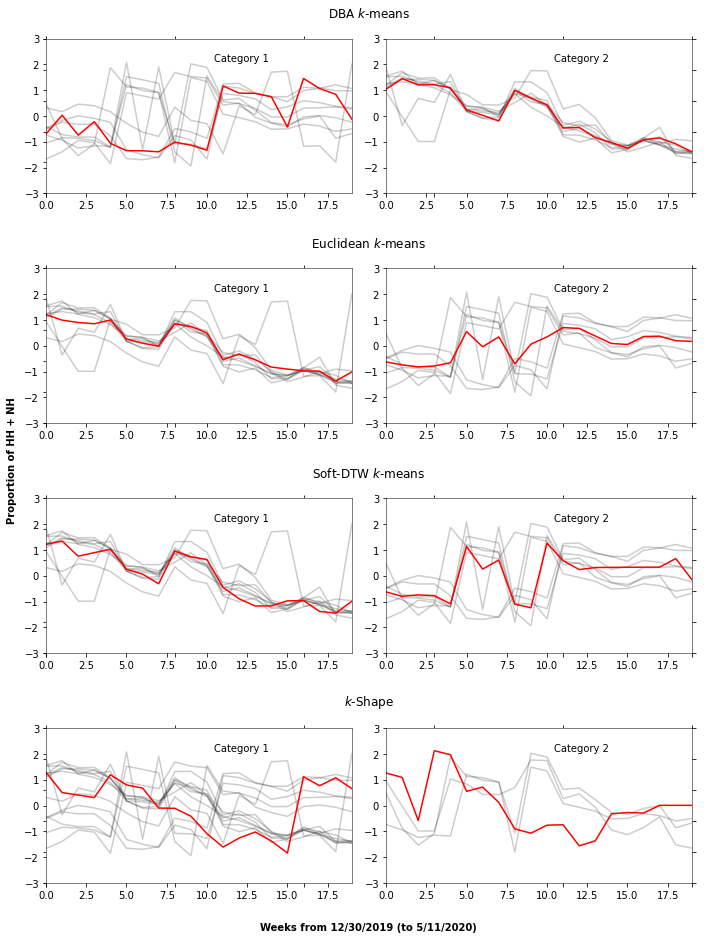

In [16]:
# SUPPLEMENTAL REFERENCE FIGURE
plt.figure()
fig, big_axes = plt.subplots(4,1,figsize=(10, 13),sharey=True)
tick_size = 10

fig.patch.set_facecolor('white')
titles = ["DBA $k$-means","Euclidean $k$-means","Soft-DTW $k$-means","$k$-Shape"]

for row, big_ax in enumerate(big_axes, start=1):
    big_ax.set_title(titles[0]+'\n', fontsize=12)
    big_ax.tick_params(labelcolor=(1.,1.,1., 0.0), top='off', bottom='off', left='off', right='off')
    titles.pop(0)
    big_ax._frameon = False
    
# DBA-k-means
for yi in range(2):
    ax = fig.add_subplot(4, 2, yi + 1)
    for xx in X_train[y_pred_dba == yi]:
        plt.plot(xx.ravel(), "k-", alpha=.2)
    plt.plot(dba_km.cluster_centers_[yi].ravel(), "r-")
    
    for axis in ['top','bottom','left','right']:
        ax.spines[axis].set_linewidth(0.5)
    ax.tick_params(axis='x',labelsize=tick_size)
    ax.tick_params(axis='y',labelsize=tick_size)
        
    plt.xlim(0, sz-1)
    plt.ylim(-3, 3)
    plt.text(0.55, 0.85,'Category %d' % (yi + 1),
             transform=plt.gca().transAxes,fontsize=tick_size)

# Euclidean-k-means
for yi in range(2):
    ax = fig.add_subplot(4, 2, yi + 3)
    for xx in X_train[y_pred_km == yi]:
        plt.plot(xx.ravel(), "k-", alpha=.2)
    plt.plot(km.cluster_centers_[yi].ravel(), "r-")
    
    for axis in ['top','bottom','left','right']:
        ax.spines[axis].set_linewidth(0.5)
    ax.tick_params(axis='x',labelsize=tick_size)
    ax.tick_params(axis='y',labelsize=tick_size)
            
    plt.xlim(0, sz-1)
    plt.ylim(-3, 3)
    plt.text(0.55, 0.85,'Category %d' % (yi + 1),
             transform=plt.gca().transAxes,fontsize=tick_size)

# Soft-DTW-k-means
for yi in range(2):
    ax = fig.add_subplot(4, 2, yi + 5)
    for xx in X_train[y_pred_sdtw_km == yi]:
        plt.plot(xx.ravel(), "k-", alpha=.2)
    plt.plot(sdtw_km.cluster_centers_[yi].ravel(), "r-")
    
    for axis in ['top','bottom','left','right']:
        ax.spines[axis].set_linewidth(0.5)
    ax.tick_params(axis='x',labelsize=tick_size)
    ax.tick_params(axis='y',labelsize=tick_size)
        
    plt.xlim(0, sz-1)
    plt.ylim(-3, 3)
    plt.text(0.55, 0.85,'Category %d' % (yi + 1),
             transform=plt.gca().transAxes,fontsize=tick_size)

# k-Shape
for yi in range(2):
    ax = fig.add_subplot(4, 2, yi + 7)
    for xx in X_train[y_pred_ks == yi]:
        plt.plot(xx.ravel(), "k-", alpha=.2)
    plt.plot(ks.cluster_centers_[yi].ravel(), "r-")
    
    for axis in ['top','bottom','left','right']:
        ax.spines[axis].set_linewidth(0.5)
    ax.tick_params(axis='x',labelsize=tick_size)
    ax.tick_params(axis='y',labelsize=tick_size)
        
    plt.xlim(0, sz-1)
    plt.ylim(-3, 3)
    plt.text(0.55, 0.85,'Category %d' % (yi + 1),
             transform=plt.gca().transAxes,fontsize=tick_size)

fig.text(0.525, 0, 'Weeks from 12/30/2019 (to 5/11/2020)', fontsize=10, ha='center', va='center',weight='bold')
fig.text(0.03, 0.5, 'Proportion of HH + NH', fontsize=10, ha='center', va='center', rotation='vertical',weight='bold')

plt.tight_layout(h_pad=0.2, w_pad=1.25)
plt.show()

# Linear (Hotspots Visits)

In [17]:
# city figure titles
titles = {'fort worth':'Fort Worth, TX', 'austin':'Austin, TX', 'houston':'Houston, TX', 'dallas':'Dallas, TX', 'san antonio':'San Antonio, TX',
         'san jose':'San Jose, CA', 'san francisco':'San Francisco, CA', 'san diego':'San Diego, CA', 'los angeles':'Los Angeles, CA',
         'seattle':'Seattle, WA', 'chicago':'Chicago, IL', 'detroit':'Detroit, MI', 'phoenix':'Phoenix, AZ',
         'philadelphia':'Philadelphia, PA', 'new york':'New York, NY', 'jacksonville':'Jacksonville, FL'}

# order of cities by category 1/2
c1 = ['san diego','phoenix','new york','dallas','fort worth','houston','san antonio','austin']
c2 = ['detroit','jacksonville','chicago','los angeles','san francisco','seattle','philadelphia','san jose']
clusters = c1 + c2
clusters = list(map(lambda x: x + '_network_analysis.pkl', clusters))

# read into dataframe
dfs = []
[dfs.append(pd.read_pickle(f)) for f in clusters]

# shelter-in-place dictionary
with open('SIP.csv', mode='r') as infile:
    reader = csv.reader(infile)
    sip = {rows[0]:rows[1] for rows in reader}
    
# first cases dictionary
with open('First Case.csv', mode='r') as infile:
    reader = csv.reader(infile)
    first_case = {rows[0]:rows[1] for rows in reader}

In [18]:
def hotspot_visits(measures,absolute=True):
    fig, axs = plt.subplots(4, 4,figsize=(45,30))
    plt.subplots_adjust(wspace=0.25, hspace=0.3,
                        left=0.125, right=0.9,
                        top=0.95,    bottom=0.1)

    i = 0
    for row in range(4):
        for col in range(4):
            df = dfs[i]
            df['date'] = pd.to_datetime(df['date'])
            city = df.city[0]

            tf = df[['date','city']].copy()
            for measure in measures:
                tf[measure] = df[measure].rolling(4).mean()

            df = tf[3:].copy()

            ax = df[[measures[0],'date']].plot(x='date',ax=axs[row,col],legend=None,linewidth=4,color='dodgerblue')
            ax = df[[measures[1],'date']].plot(x='date',ax=axs[row,col],legend=None,linewidth=2,color='darkorange')
            ax = df[[measures[2],'date']].plot(x='date',ax=axs[row,col],legend=None,linewidth=4,color='mediumpurple')
            ax = df[[measures[3],'date']].plot(x='date',ax=axs[row,col],legend=None,linewidth=2,color='forestgreen')

            axs[row, col].set_title(titles.get(city),fontsize=34)
            axs[row, col].tick_params(axis='x',labelsize=26, rotation=0)
            axs[row, col].tick_params(axis='y',labelsize=26)

            x_axis = axs[row, col].get_xaxis()
            x_label = x_axis.get_label()
            x_label.set_visible(False)

            ax.axvline(x=pd.to_datetime(first_case.get(city)), color='darkblue',linewidth=4)
            ax.axvline(x=pd.to_datetime(sip.get(city)), color='r',linewidth=4)

            date_form = DateFormatter("%-U")
            ax.xaxis.set_major_formatter(date_form)
            axs[row, col].set_xticks(axs[row, col].get_xticks()[::2])

            handles, labels = axs[row, col].get_legend_handles_labels()

            i += 1

    fig.legend(handles, labels=['HH','HN','NH','NN','First Case','Shelter in Place'], loc='lower center',bbox_to_anchor=[0.4245, 0.0675],ncol=6,prop={'size': 34})       
    fig.text(0.5, 0.12, 'Weeks from 12/30/2019 (to 5/11/2020)', fontsize=38, ha='center', va='center',weight='bold')
    
    if absolute:
        fig.text(0.085, 0.56, 'Visit Count', fontsize=38, ha='center', va='center', rotation='vertical',weight='bold')
    else:
        fig.text(0.085, 0.58, 'Visit Count Proportion', fontsize=38, ha='center', va='center', rotation='vertical',weight='bold')

    return plt

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:44: UserWarning:

You have mixed positional and keyword arguments, some input may be discarded.



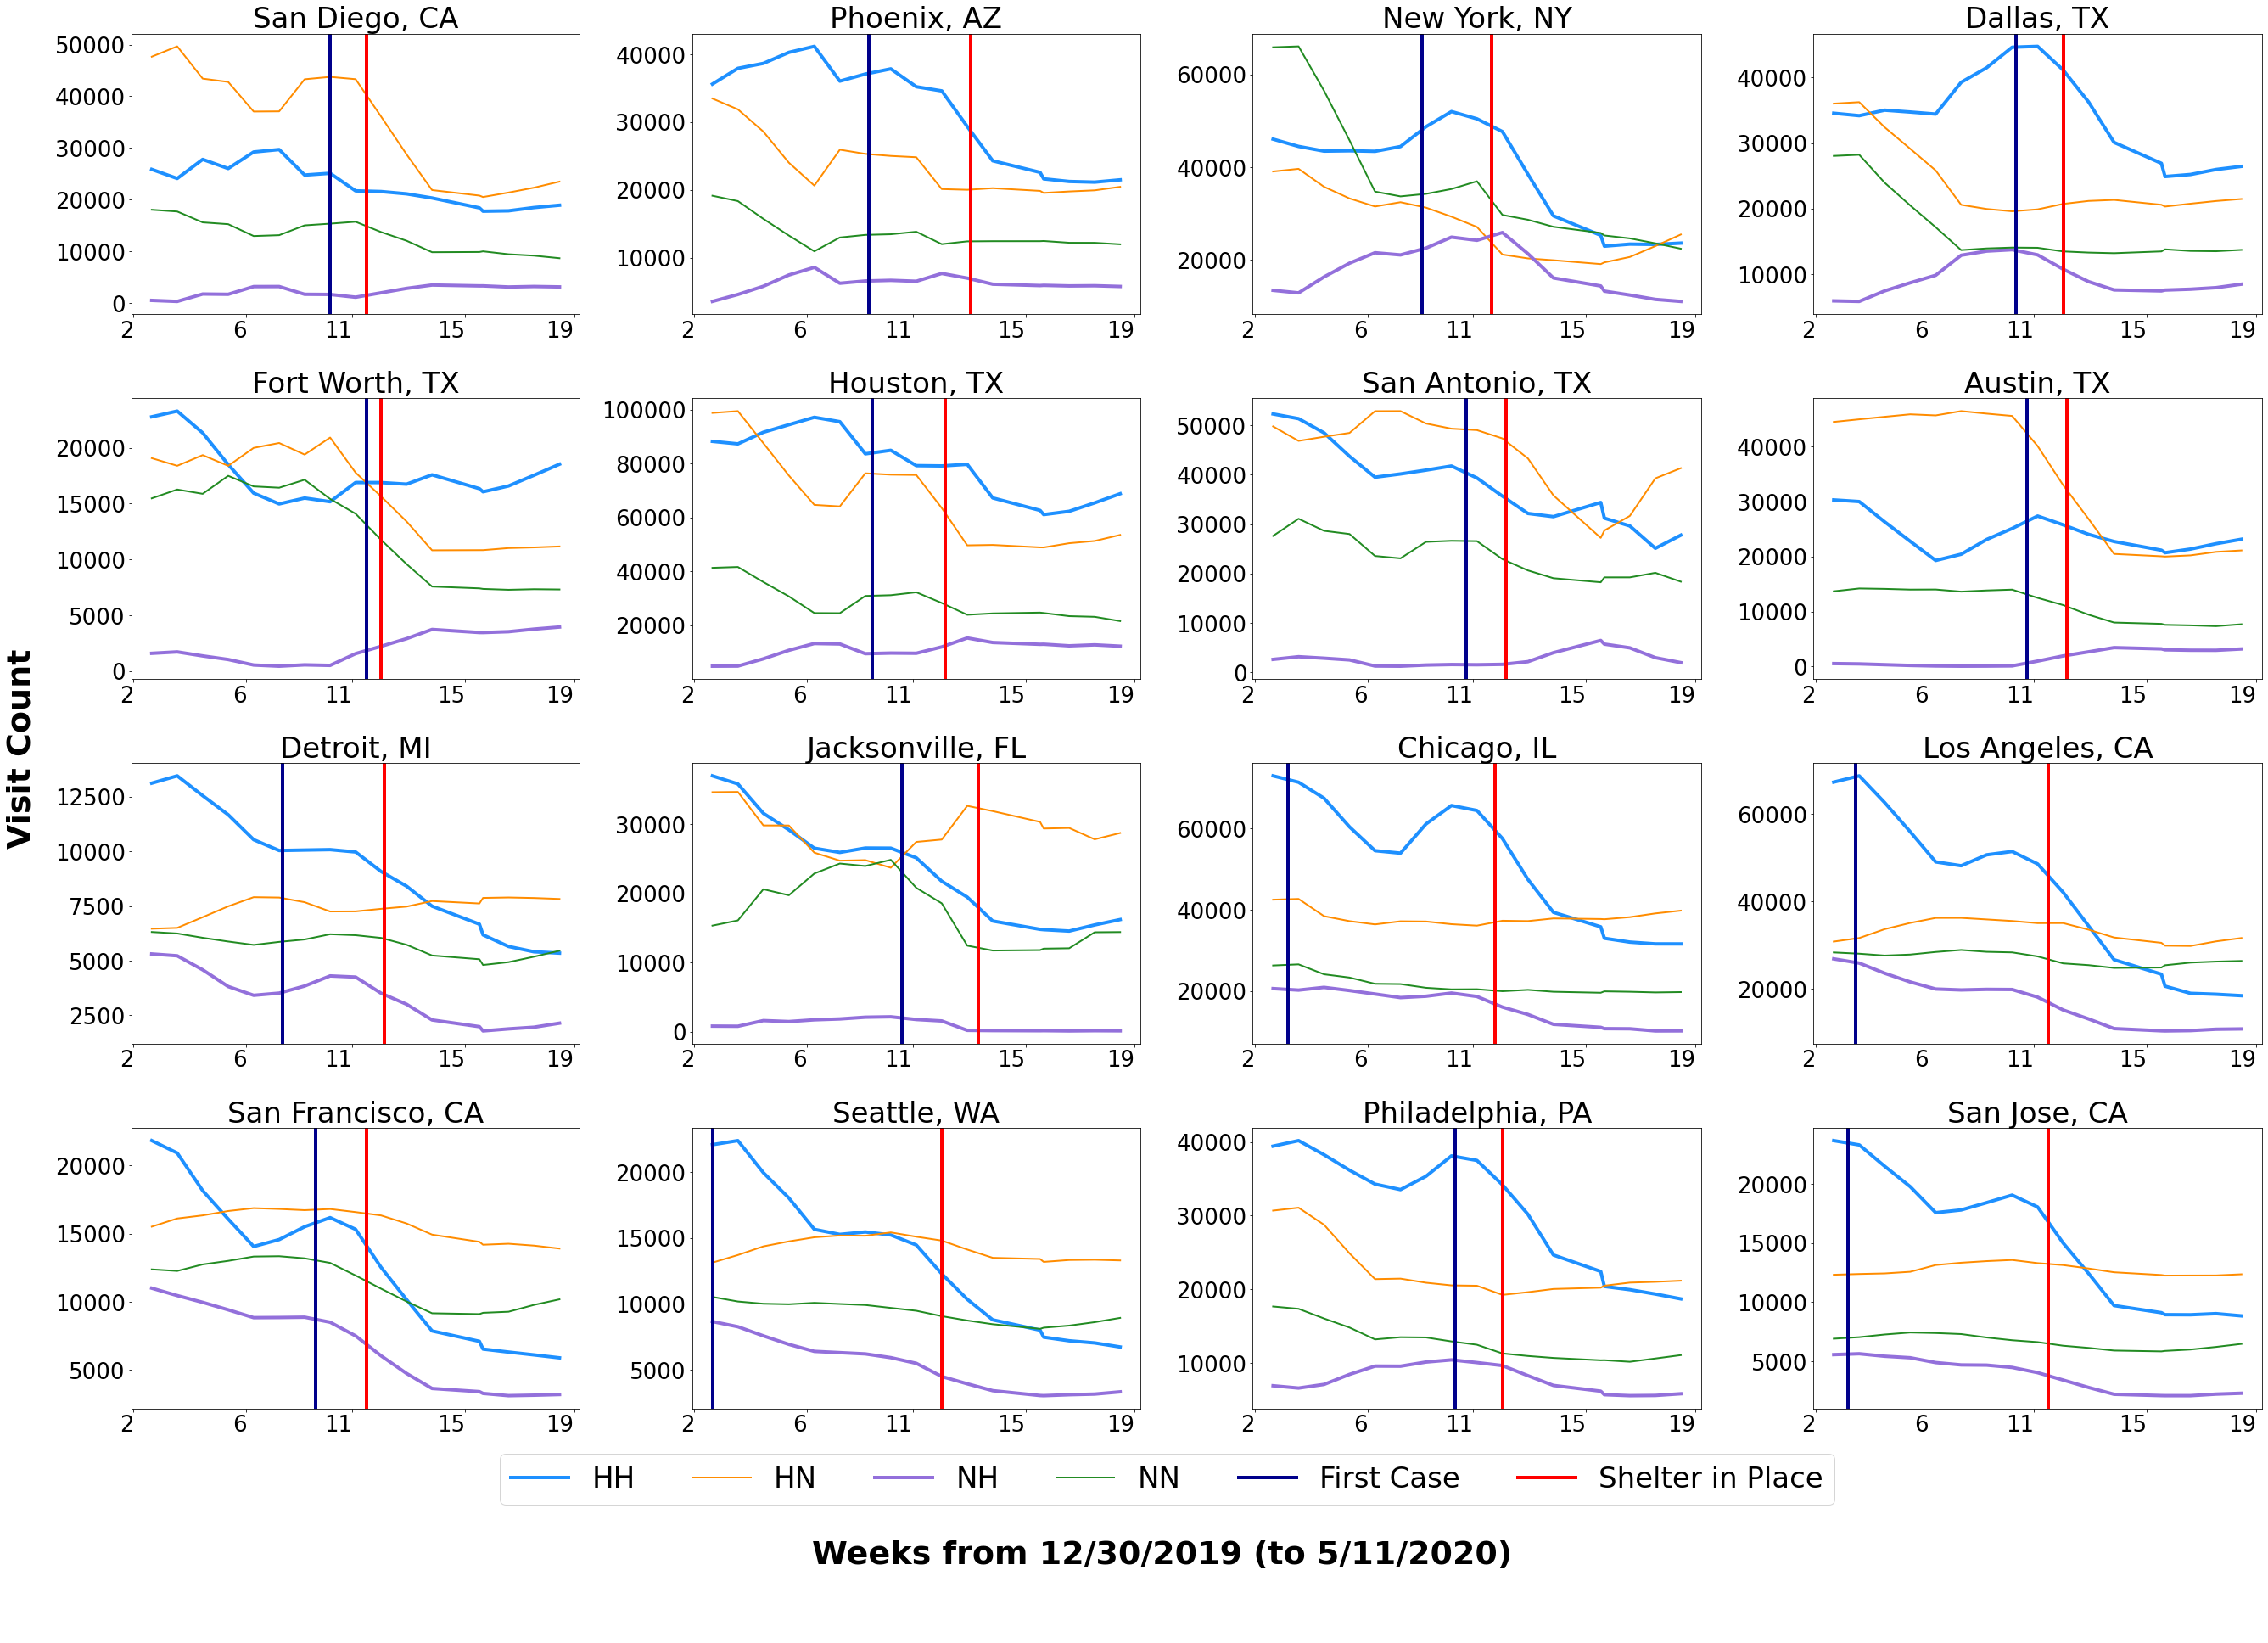

In [19]:
# absolute rolling figure
measures = ['hh_absolute','hn_absolute','nh_absolute','nn_absolute']
plt = hotspot_visits(measures)
plt.show()

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:44: UserWarning:

You have mixed positional and keyword arguments, some input may be discarded.



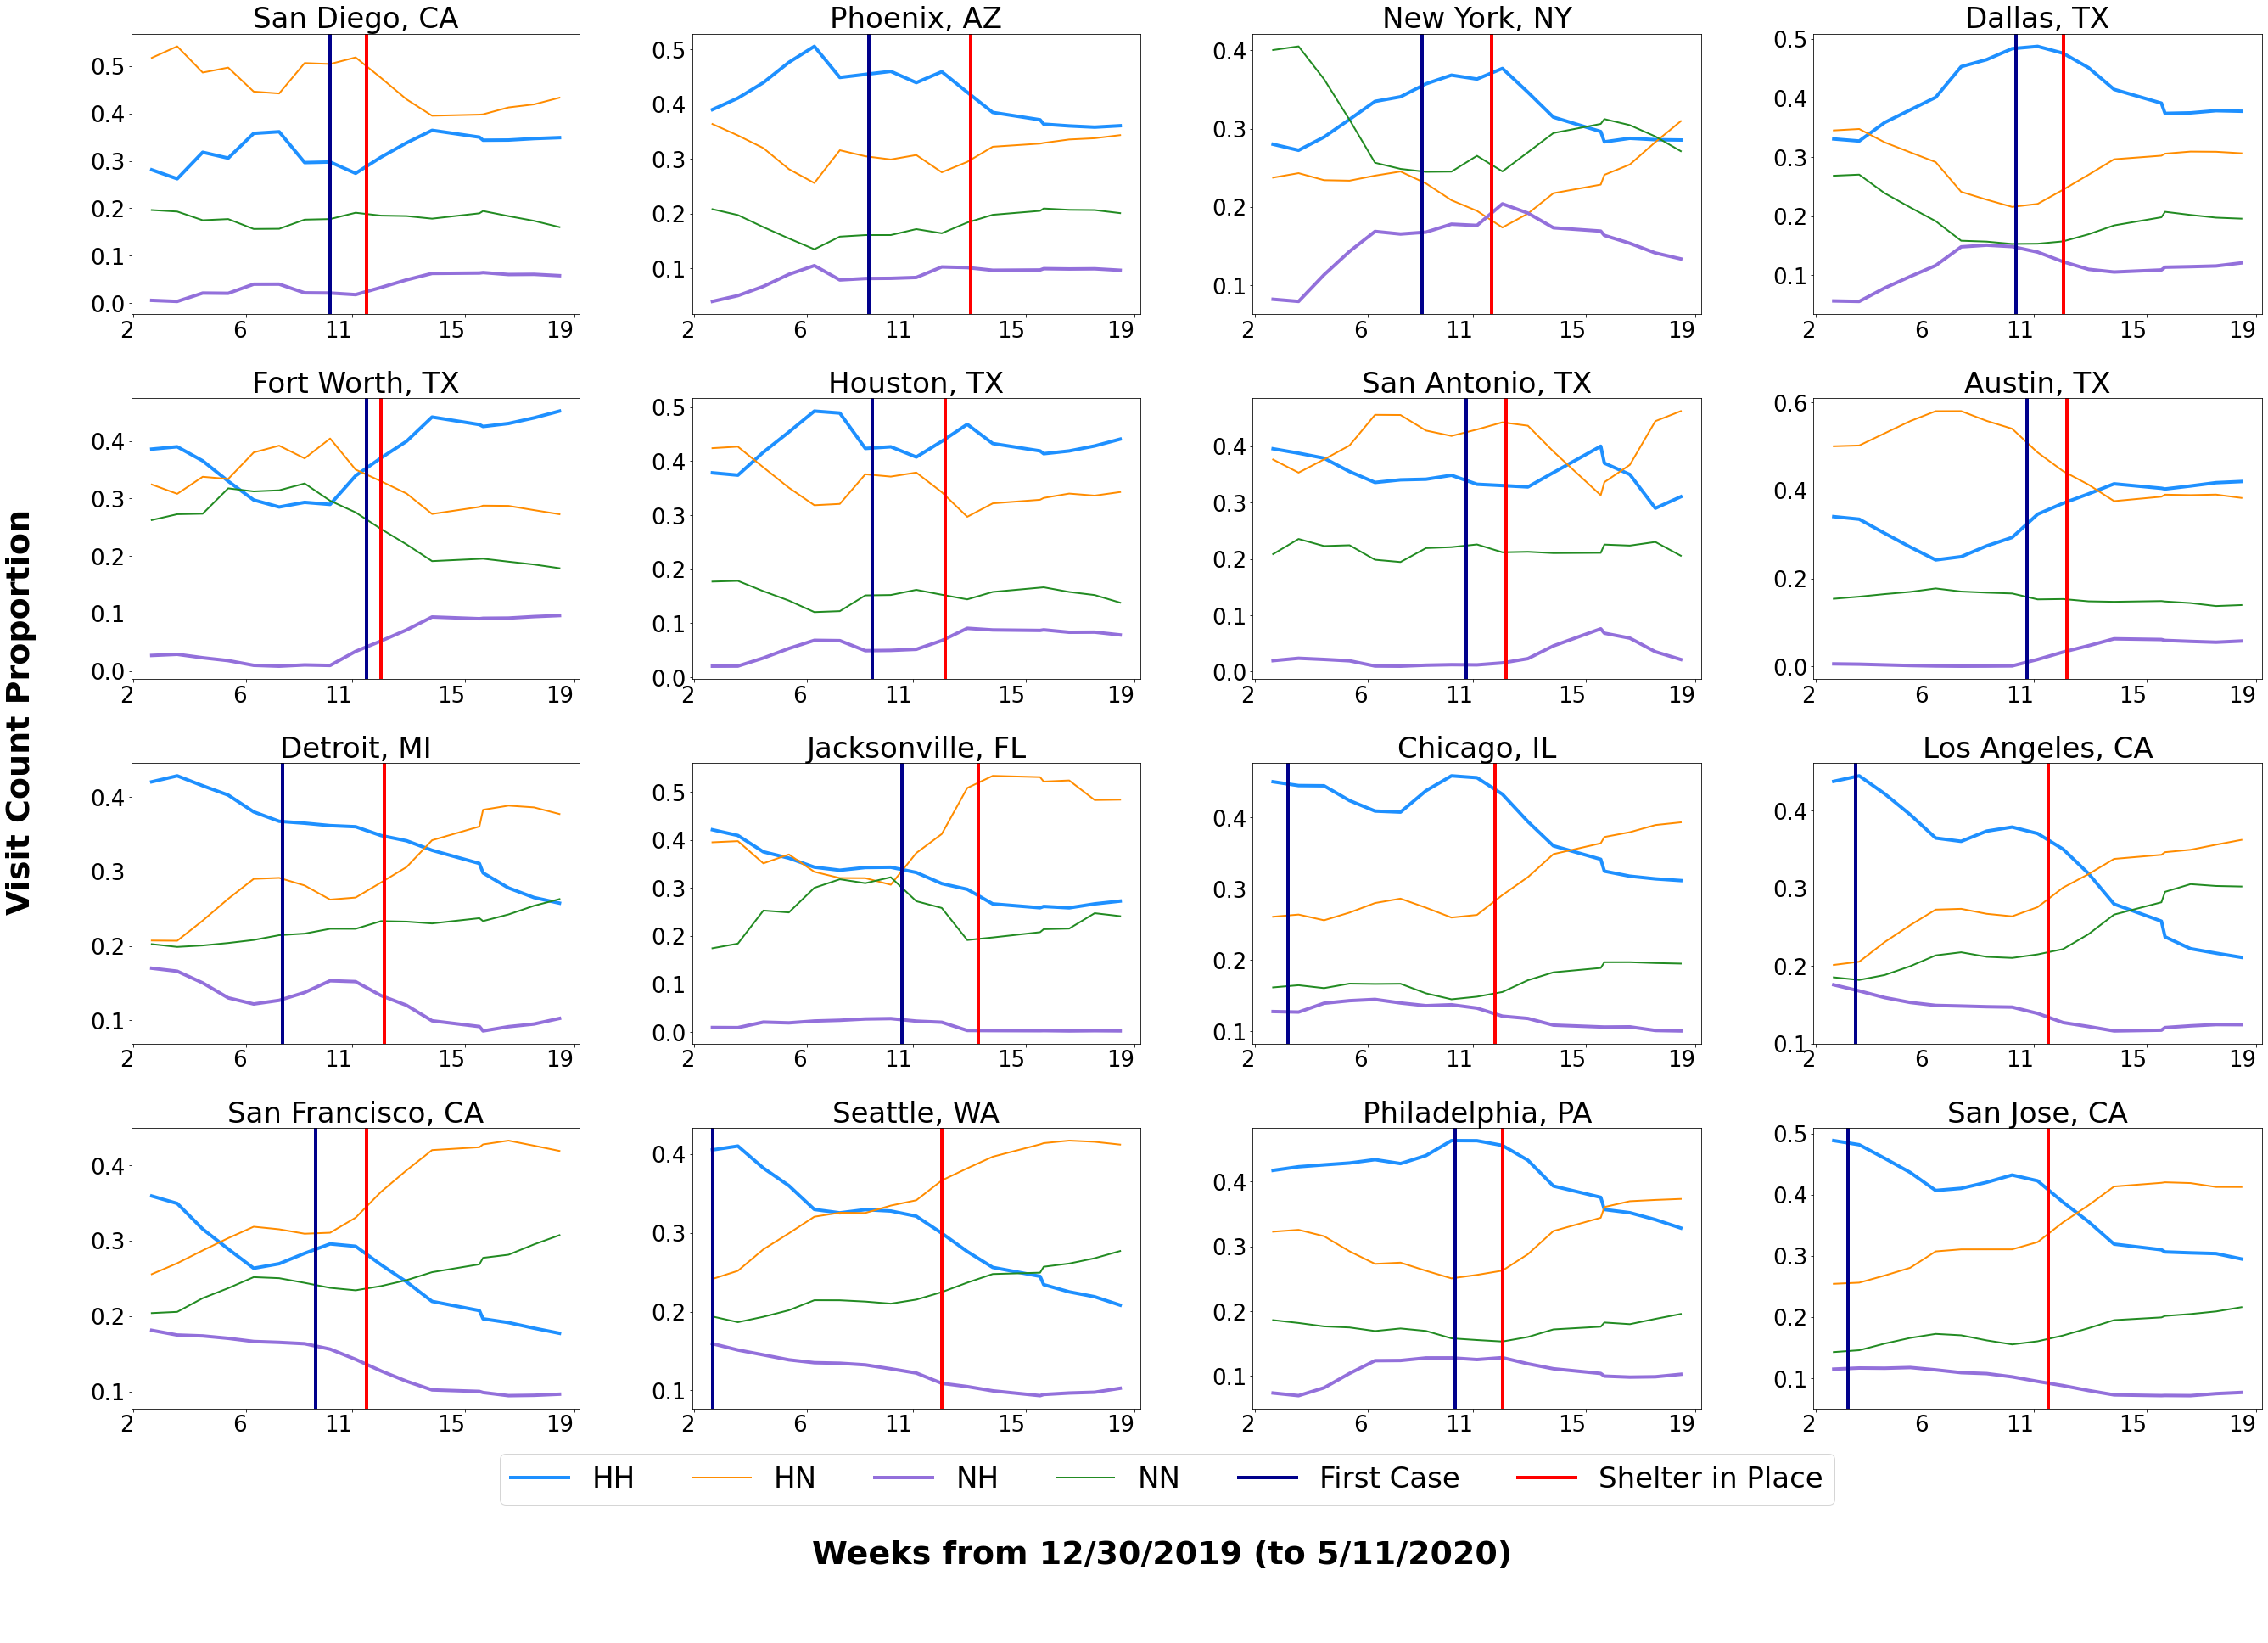

In [20]:
# proportion rolling figure
measures = ['hh_proportion','hn_proportion','nh_proportion','nn_proportion']
plt = hotspot_visits(measures,False)
plt.show()